In [4]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import sys
import threading
import csv

In [2]:
tsp_dir = os.getcwd() + os.sep + 'TSPLIB' + os.sep

In [3]:
tsp_files_list = os.listdir(tsp_dir)

In [4]:
def getOptmSolns():
    file = open(tsp_dir + os.sep + 'solutions', 'r')
    lines = file.readlines()
    resDict = {}
    for l in lines:
        s = l.split(' : ')
        s[0] += '.tsp'
        s[1] = s[1][:-1]
        resDict[s[0]] = float(s[1])
    return resDict

In [5]:
optmSolns = getOptmSolns()

In [6]:
subprocess.run('make christofides', shell=True, capture_output=True)

CompletedProcess(args='make christofides', returncode=0, stdout=b"make: 'christofides' is up to date.\n", stderr=b'')

In [7]:
def parseOutputString(outputStr):
    lines = outputStr.split('\n')
    resultDict = {}
    for i in range(len(lines)-1):
        line = lines[i]
        s = line.split()
        if(i == 0):
            resultDict[i] = [s[1]]
        else:
            resultDict[i] = s[1:]
    return resultDict

In [8]:
def getSupportedFilesList():
    tsp_files_list = os.listdir(tsp_dir)
    supportedFiles = []
    keyWord = 'EDGE_WEIGHT_SECTION'
    for filename in tsp_files_list:
        if(filename.find('.tsp') == -1):
            continue
        foundKeyWord = False
        file = open(tsp_dir + os.sep + filename, 'r')
        lines = file.readlines()
        for line in lines:
            if(line.find(keyWord) != -1):
                foundKeyWord = True
                break
        if(foundKeyWord == False):
            supportedFiles.append(filename)
    return supportedFiles

In [9]:
supported_tsp_files_list = getSupportedFilesList()

In [10]:
def launchChristofides(filename = 'gr48.tsp', perturbation_percentage = 0.0):
    filename = filename
    if(filename not in supported_tsp_files_list):
        print('WARNING: You are running the algorithm on an unsupported file, Perturbation does not work.')
    filename = 'TSPLIB' + os.sep + filename
    command = './christofides' + ' -f ' + filename + ' -p ' + str(perturbation_percentage)
    out = subprocess.run([command], shell=True, capture_output=True)
    output = out.stdout.decode('utf-8')
    resultDict = parseOutputString(output)
    return resultDict

In [11]:
def launchChristofidesThreadSafe(resultDictList, listLock, filename = 'gr48', perturbation_percentage = 0.0):
    dictToAdd = launchChristofides(filename, perturbation_percentage)
    listLock.acquire()
    resultDictList.append(dictToAdd)
    listLock.release()
    return    

In [12]:
def runExpt(filename, perturbation_percentage, num_threads = 15):
    resultList = []
    listLock = threading.Lock()
    threads = []
    for i in range(num_threads):
        t = threading.Thread(target = launchChristofidesThreadSafe, args = (resultList, listLock, filename, perturbation_percentage))
        threads.append(t)
        t.start()
    for t in threads:
        t.join()
    return resultList

In [13]:
def getAvgList(inpDict=[]):
    l = [0.0 for i in range(5)]
    n = len(inpDict)
    for d in inpDict:
        try:
            l[0] += float(d[0][0])
        except:
            n -= 1
            continue
        for i in range(4):
            l[i+1] += float(d[i+1][1])
    if(n == 0):
        print('fhere', end ='\t')
        return l
    for i in range(5):
        l[i] = l[i]/n
    return l

In [14]:
def getNumFromString(s):
    numStr = ''
    for c in list(s):
        if(c.isdigit()):
            numStr += (c)
    return int(numStr)

In [15]:
def getData(MAX_N = 1000, NUM_OBSERVATIONS = 15, NUM_FILES = len(supported_tsp_files_list), ppList = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    data = {}
    if(NUM_FILES > len(supported_tsp_files_list)):
        print('There are only', len(supported_tsp_files_list), 'files available')
        NUM_FILES = len(supported_tsp_files_list)
    for i in range(NUM_FILES):
        filename = supported_tsp_files_list[i]
        if(getNumFromString(filename) > MAX_N):
            continue
        print(filename, end='\t')
        for j in range(len(ppList)):
            pp = ppList[j]
            output = runExpt(filename, pp, NUM_OBSERVATIONS)
            print(pp, end = '\t')
            l = getAvgList(output)
            data[(filename, pp)] = []
            for k in range(5):
                data[(filename, pp)].append(l[k])
        print(u'\u2713')
    return data

In [16]:
##### Uncomment last to run for different parameters, saved variable data is for MAX_N = 1000, NUM_OBS = 20, NUM_FILES = 100
%store -r data
# data = getData(MAX_N = 1000, NUM_OBSERVATIONS = 20, NUM_FILES = 100)

In [17]:
# print(data)

In [18]:
ppList = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
allTables = []
for t in range(5):
    table = []
    l1 = []
    l1.append('FileName\Heur: ' + str(t))
    for pp in ppList:
        l1.append(pp)
    table.append(l1)
    for file in supported_tsp_files_list:
        if((file, 0.0) not in data.keys()):
            continue
        l = []
        l.append(file)
        reqdStr = ''
        for pp in ppList:
            num = data[(file, pp)][t]
            optNum = optmSolns[file]
            reqdStr = str(round((num/optNum), 3)) + ' | ' + str(round(num, 3))
            l.append(reqdStr)
        table.append(l)
    allTables.append(table)

In [19]:
def writeCsvTableToDisk(filename, table):
    with open(filename+'.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(table)
    return

In [20]:
for t in range(len(allTables)):
    writeCsvTableToDisk('Heuristic '+ str(t), allTables[t])

In [21]:
# print(allTables[1])

In [22]:
# %store data

In [3]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 00F7-C470

 Directory of c:\Users\subbu\Documents\CS6100-Christofides-ShortCutting-Heurisitcs

24-May-21  07:12 PM    <DIR>          .
21-May-21  06:22 AM    <DIR>          ..
24-May-21  07:12 PM                64 .gitignore
24-May-21  07:12 PM    <DIR>          .vscode
24-May-21  07:12 PM           131,512 christofides
24-May-21  07:12 PM            12,345 Christofides.h
24-May-21  07:12 PM             4,507 Example.cpp
24-May-21  07:12 PM             4,399 filename
24-May-21  07:12 PM             6,660 Heuristic 0.csv
24-May-21  07:12 PM             7,694 Heuristic 1.csv
24-May-21  07:12 PM             7,656 Heuristic 2.csv
24-May-21  07:12 PM             7,663 Heuristic 3.csv
24-May-21  07:12 PM             7,651 Heuristic 4.csv
24-May-21  07:12 PM               193 launchNotebook.bat
23-Apr-21  06:14 AM               922 makefile
22-Apr-21  05:48 PM    <DIR>          Matching
22-Apr-21  05:48 PM             1,457 MST.h
22-Ap

In [46]:
for i,j in enumerate([4,5,6]):
    print(i,j)

0 4
1 5
2 6


In [5]:
hur_files = ['Heuristic 1.csv', 'Heuristic 2.csv', 'Heuristic 3.csv', 'Heuristic 4.csv']
eps = [0.0,0.01,0.02,0.05,0.1,0.2,0.3]
tsp_files = {}
for i,j in enumerate(np.loadtxt('Heuristic 1.csv', dtype = 'str',skiprows=1,delimiter=',',usecols=0)):
    tsp_files[j] = i
h_ratios = []
for i in hur_files:
    arr = np.loadtxt(i, dtype = 'str',skiprows=1,delimiter=',',usecols=range(1,8))
    arr = np.array([[float(arr[j][k].split()[0]) for k in range(np.shape(arr)[1])] for j in range(np.shape(arr)[0])])
    h_ratios.append(arr)

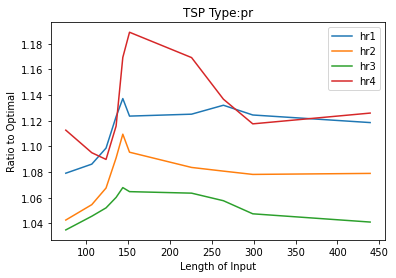

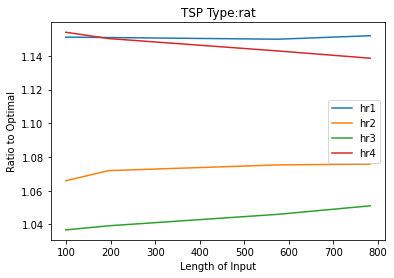

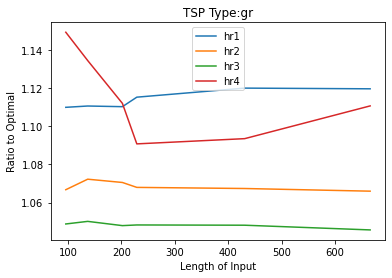

In [18]:
tspn_files = ['pr', 'rat', 'gr']
for i in tspn_files:
    fnames = []; x = []
    for j in tsp_files.keys():
        if i == j[:len(i)]:
            fnames.append(j)
            x.append(int(j[len(i):-4]))
    fnames = [fnames[j] for j in np.argsort(x)]
    x.sort()
    for j in range(4):
        y = [h_ratios[j][tsp_files[k]][0] for k in fnames]
        ysmoothed = gaussian_filter1d(y, sigma=1)
        plt.plot(x,ysmoothed)
    plt.legend(['hr1', 'hr2', 'hr3', 'hr4'])
    plt.title('TSP Type:'+i)
    plt.xlabel('Length of Input')
    plt.ylabel('Ratio to Optimal')
    plt.show()

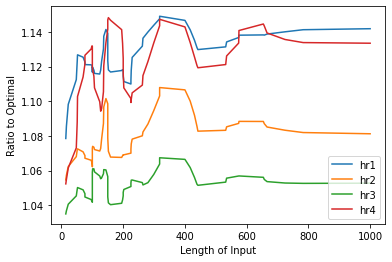

In [17]:
from scipy.ndimage.filters import gaussian_filter1d
fnames = [];x = []
for j in tsp_files.keys():
    fnames.append(j)
    i = 0
    while(not j[i:-4].isdigit()):
        i+=1
    x.append(int(j[i:-4]))
fnames = [fnames[j] for j in np.argsort(x)]
x.sort()
for j in range(4):
    y = [h_ratios[j][tsp_files[k]][0] for k in fnames]
    ysmoothed = gaussian_filter1d(y, sigma=2)
    plt.plot(x,ysmoothed)
plt.legend(['hr1', 'hr2', 'hr3', 'hr4'])
plt.title('')
plt.xlabel('Length of Input')
plt.ylabel('Ratio to Optimal')
plt.show()

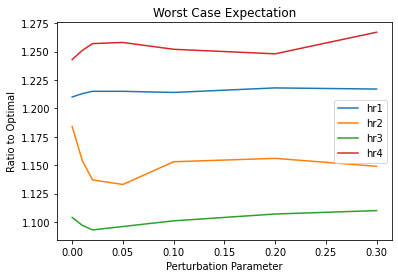

In [79]:
x = eps
for i in range(4):
    y = np.max(h_ratios[i],0)
    plt.plot(x,y)
plt.title('Worst Case Expectation')
plt.legend(['hr1', 'hr2', 'hr3', 'hr4'])
plt.xlabel('Perturbation Parameter')
plt.ylabel('Ratio to Optimal')
plt.show()

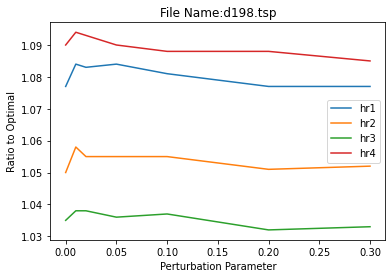

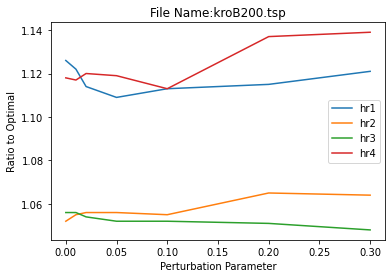

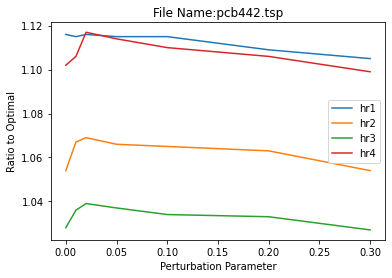

In [78]:
gen_files = ['d198.tsp', 'kroB200.tsp', 'pcb442.tsp']
x = eps
for i in gen_files:
    for j in range(4):
        y = h_ratios[j][tsp_files[i]]
        plt.plot(x,y)
    plt.legend(['hr1', 'hr2', 'hr3', 'hr4'])
    plt.title('File Name:'+i)
    plt.xlabel('Perturbation Parameter')
    plt.ylabel('Ratio to Optimal')
    plt.show()

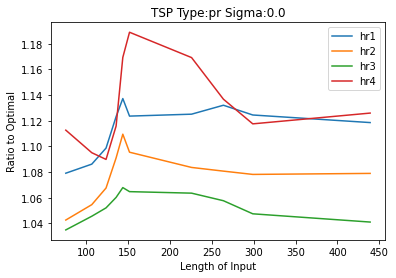

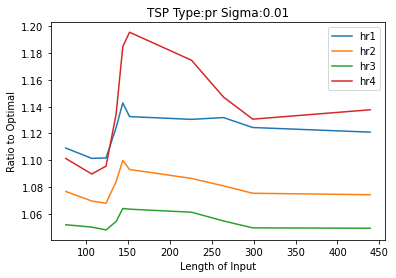

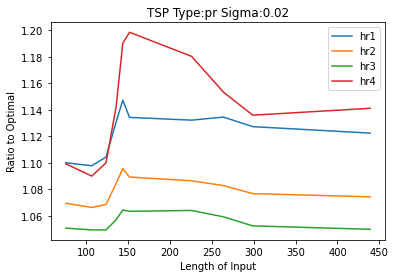

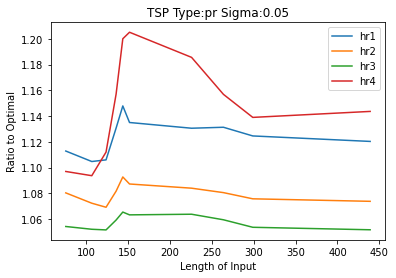

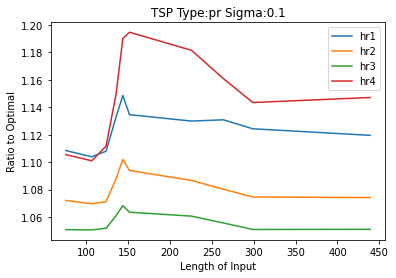

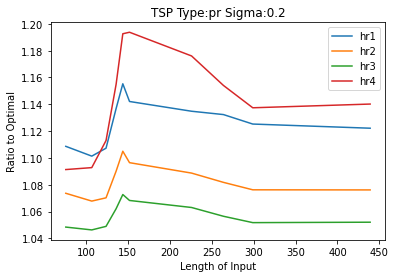

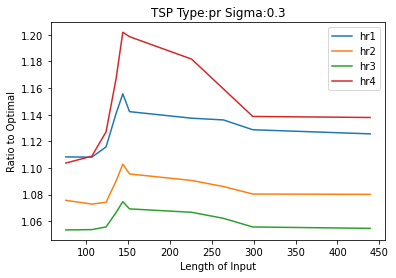

In [15]:
tspn_files = ['pr']
for pp in range(len(eps)):
    for i in tspn_files:
        fnames = []; x = []
        for j in tsp_files.keys():
            if i == j[:len(i)]:
                fnames.append(j)
                x.append(int(j[len(i):-4]))
        fnames = [fnames[j] for j in np.argsort(x)]
        x.sort()
        for j in range(4):
            y = [h_ratios[j][tsp_files[k]][pp] for k in fnames]
            ysmoothed = gaussian_filter1d(y, sigma=1)
            plt.plot(x,ysmoothed)
        plt.legend(['hr1', 'hr2', 'hr3', 'hr4'])
        plt.title('TSP Type:'+i+' Sigma:'+str(eps[pp]))
        plt.xlabel('Length of Input')
        plt.ylabel('Ratio to Optimal')
        plt.show()